<a href="https://colab.research.google.com/github/DenisPerez/NN_Tests_DG/blob/main/Experimento3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 3: Mejores métodos

**Propósito:** Estudiar el desempeño y la velocidad de convergencia basado en epochs de los métodos cíclicos y el método decreciente (propio) combinados con la estrategia de Momentum


> **Nota:** Si se utilizará Google Colab como ambiente para las pruebas, se debe tomar la referencia al repositorio para que la libreta tenga acceso a los archivos que requiere


In [1]:
!git clone https://github.com/DenisPerez/NN_Tests_DG.git
%cd NN_Tests_DG
%ls

Cloning into 'NN_Tests_DG'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 99 (delta 44), reused 51 (delta 12), pack-reused 0
Unpacking objects: 100% (99/99), 15.23 MiB | 2.96 MiB/s, done.
/content/NN_Tests_DG
classes.py          get_images.py             LearningRateStudy.ipynb
Dataset/            Iteracion1.ipynb          NN_from_Scratch.ipynb
Decay.ipynb         Iteracion1_new.ipynb      NN_Pytorch.ipynb
Experimento2.ipynb  Iteracion_2.ipynb         ResNet56_cifar10.ipynb
Experimento3.ipynb  Iteracion3_Mejores.ipynb  SGD_Momentum_RMSProp_Adam.ipynb


Al tener disponible los archivos a referenciar, se realizan las importaciones necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images
from classes import CyclicLRGiselt_Denis

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

### Extracción del conjunto de datos: MNIST

Este conjundo de datos esta basado en 60.000 imá-
genes en el conjunto de entrenamiento y 10.000 en el conjunto de prueba de 28x28 píxeles
que representan dígitos del 0 al 9 escritos a mano y es considerado el "Hola Mundo" en el
área de la ciencia de datos. Sin embargo, **10.000  de las muestras del conjunto de entrenamiento serán destinadas al conjunto de validación** con el que se te tomará la precisión en el entrenamiento.

In [3]:
MNIST_PATH = './Dataset/'

In [4]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [5]:
# Segmento para el conjunto de entrenamiento
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

# Segmento para el conjunto de validacion
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

# Segmento para el conjunto de prueba
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

### Normalización de la muestra

In [6]:
def normalize(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

Se toma la desviación estandar y la media de cada conjunto de datos y se llama a la función *normalize*

In [7]:
# Calculo para el conjunto de entrenamiento
x_mean = x_train.mean()
x_std = x_train.std()
x_train = normalize(x_mean, x_std, x_train)

# Calculo para el conjunto de validación
x_mean = x_val.mean()
x_std = x_val.std()
x_val = normalize(x_mean, x_std, x_val)

# Calculo para el conjunto de prueba
x_mean = x_test.mean()
x_std = x_test.std()
x_test = normalize(x_mean, x_std, x_test)

### Visualización de la muestra

In [8]:
# Dimensiones del conjunto de datos de entrenamiento
x_test.shape

(10000, 784)

In [9]:
# Dimensiones del conjunto de datos de prueba:
y_train.shape

(50000, 1)

In [10]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 1


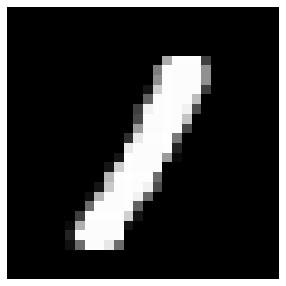

In [11]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Creación de mini lotes

In [12]:
def create_minibatches(x, y, mb_size, shuffle = True):
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Conversión de arreglo a tensores para todos los conjuntos de datos

In [13]:
# Conversion para el conjunto de entrenamiento
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

# Conversion para el conjunto de validación
x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

# Conversion para el conjunto de prueba
x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

### Habilitar el uso del CPU

Primero se consulta si se tiene la plataforma CUDA disponible para la utilización de los recursos de GPU

In [14]:
torch.cuda.is_available()

False

En caso de no tenerse, se asigna el trabajo de computo al CPU

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cpu


# Funciones 

### Función para calcular la precisión


In [16]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

### Función para realizar la propagación hacia atrás y la actualización de parámetros

In [17]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    epoch_acc = 0.0
    i = 0
    iter_found = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (i < 100):
        if (epoch_acc >= 0.95 and unregistered):
          iter_found = i
          unregistered = False
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr_list.append(optimizer.param_groups[0]['lr'])
        i+=1
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        # print(f'Epoch: {len(acc_list)}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list, iter_found 

### Operaciones en las trazas

In [18]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

In [19]:
def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

In [20]:
def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

# Experimentos

### Variables globales

In [21]:
MAX_ITERATIONS = 10
layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784
first_i = 0

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
resultados = {}


## Acelerador: Adam

$\alpha: 1x10^{-2}$ 

$beta1: 0.9$

$beta2: 0.999$

In [22]:
def Adam():
    modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                        nn.Linear(in_features=layer2, out_features=10))
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list, adam_epochs = train(modelAdam,optimiserAdam,None, mb_size)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs

In [23]:

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0
resultados['adam']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time
    resultados['adam']['epochs'] += adam_epochs

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time']/ MAX_ITERATIONS
resultados['adam']['epochs'] = resultados['adam']['epochs'] / MAX_ITERATIONS


RuntimeError: ignored

## Tasa de aprendizaje cíclica con Momentum

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción igual a 

$$
proporción\_de\_cambio = \frac{max\_ta - base\_ta}{n}
$$

Esta implementación facilitada por PyTorch, está basada en la publicación de Tasas de aprendizaje cíclico para la red neuronal de entrenamiento (*Cyclical Learning Rates for Training Neural Networks* o por sus siglas CLR) de Leslie Smith, 2017.

$\alpha: 1x10^{-2}$

$beta: 0.9$

In [ ]:
def CyclicMomentum():
    modelCyclicMomentum = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelCyclicMomentum.parameters(), lr=lr, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclicMomentum_acc_list, cyclicMomentum_cost_list, cyclicMomentum_lr_list, cyclicMomentum_epochs = train(modelCyclicMomentum, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    cyclicMomentum_time = start.elapsed_time(end)

    cyclicMomentum_acc = accuracy(modelCyclicMomentum, x_test_tensor,  y_test_tensor, mb_size)

    return cyclicMomentum_acc_list, cyclicMomentum_cost_list, cyclicMomentum_lr_list, cyclicMomentum_time, cyclicMomentum_acc, cyclicMomentum_epochs

In [ ]:
resultados['cyclicMomentum'] = {}
resultados['cyclicMomentum']['val_acc_list'] = [0]* epochs
resultados['cyclicMomentum']['test_acc'] = 0
resultados['cyclicMomentum']['cost'] = [0] * epochs
resultados['cyclicMomentum']['time'] = 0
resultados['cyclicMomentum']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    cyclicMomentum_acc_list, cyclicMomentum_cost_list, cyclicMomentum_lr_list, cyclicMomentum_time, cyclicMomentum_acc, cyclicMomentum_epochs = CyclicMomentum()
    resultados['cyclicMomentum']['val_acc_list'] = SumList(resultados['cyclicMomentum']['val_acc_list'], cyclicMomentum_acc_list)
    resultados['cyclicMomentum']['test_acc'] += cyclicMomentum_acc
    resultados['cyclicMomentum']['cost'] = SumList(resultados['cyclicMomentum']['cost'], cyclicMomentum_cost_list)
    resultados['cyclicMomentum']['time'] += cyclicMomentum_time
    resultados['cyclicMomentum']['epochs'] += cyclicMomentum_epochs

#Saving results
resultados['cyclicMomentum']['name'] = 'Ciclico Con Momentum'
resultados['cyclicMomentum']['lr'] = cyclicMomentum_lr_list
resultados['cyclicMomentum']['test_acc'] = resultados['cyclicMomentum']['test_acc'] / MAX_ITERATIONS
resultados['cyclicMomentum']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclicMomentum']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclicMomentum']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclicMomentum']['cost'], MAX_ITERATIONS))
resultados['cyclicMomentum']['time'] = resultados['cyclicMomentum']['time']/ MAX_ITERATIONS
resultados['cyclicMomentum']['epochs'] = resultados['cyclicMomentum']['epochs'] / MAX_ITERATIONS

## Tasa de aprendizaje cíclico aleatorio con Momentum


Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción aleatoria.

$base\_ta: 1x10^{-2}$

$max\_ta: 1x10^{-1}$

$n: 3$ epochs

In [ ]:
def CyclicGD_Momentum():
    
    modelRandomCyclic_Momentum= nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic_Momentum.parameters(), lr=lr, momentum=0.9)

    clr_fn = lambda x, y: random.uniform(x, y)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=2, scale_fn=clr_fn,scale_mode='chipichipi', cycle_momentum=False)

    start.record()
    random_cyclic_Momentum_acc_list, random_cyclic_Momentum_cost_list, random_cyclic_Momentum_lr_list, random_cyclic_epochs= train(modelRandomCyclic_Momentum, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    random_cyclic_Momentum_time = start.elapsed_time(end)

    random_cyclic_Momentum_acc = accuracy(modelRandomCyclic_Momentum, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_Momentum_acc_list, random_cyclic_Momentum_cost_list, random_cyclic_Momentum_lr_list, random_cyclic_Momentum_time, random_cyclic_Momentum_acc, random_cyclic_epochs

In [ ]:
resultados['random_cyclic_Momentum'] = {}
resultados['random_cyclic_Momentum']['val_acc_list'] = [0] * epochs
resultados['random_cyclic_Momentum']['test_acc'] = 0
resultados['random_cyclic_Momentum']['cost'] = [0] * epochs
resultados['random_cyclic_Momentum']['time'] = 0
resultados['random_cyclic_Momentum']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_Momentum_acc_list, random_cyclic_Momentum_cost_list, random_cyclic_Momentum_lr_list, random_cyclic_Momentum_time, random_cyclic_Momentum_acc, random_cyclic_epochs = CyclicGD_Momentum()
    a = SumList(resultados['random_cyclic_Momentum']['val_acc_list'], random_cyclic_Momentum_acc_list)
    resultados['random_cyclic_Momentum']['val_acc_list'] = SumList(resultados['random_cyclic_Momentum']['val_acc_list'], random_cyclic_Momentum_acc_list)
    resultados['random_cyclic_Momentum']['test_acc'] += random_cyclic_Momentum_acc
    resultados['random_cyclic_Momentum']['cost'] = SumList(resultados['random_cyclic_Momentum']['cost'], random_cyclic_Momentum_cost_list)
    resultados['random_cyclic_Momentum']['time'] += random_cyclic_Momentum_time
    resultados['random_cyclic_Momentum']['epochs'] += random_cyclic_epochs

#Saving results
resultados['random_cyclic_Momentum']['name'] = 'Random Ciclico con Momentum'
resultados['random_cyclic_Momentum']['lr'] = random_cyclic_Momentum_lr_list
resultados['random_cyclic_Momentum']['test_acc'] = resultados['random_cyclic_Momentum']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic_Momentum']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_Momentum']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic_Momentum']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_Momentum']['cost'], MAX_ITERATIONS))
resultados['random_cyclic_Momentum']['time'] = resultados['random_cyclic_Momentum']['time']/ MAX_ITERATIONS
resultados['random_cyclic_Momentum']['epochs'] = resultados['random_cyclic_Momentum']['epochs'] / MAX_ITERATIONS

## Tasa de aprendizaje decreciente con Momentum

Inicia con una tasa de aprendizaje $\alpha$ inicial y posee una disminución de 0.001 cada $p$ epochs.

$\alpha: 1x10^{-2}$

$beta: 0.9$

In [ ]:
def Our_Decay():
    modelOurDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=1, momentum=0.9)


    clr_fn = lambda x, y: random.uniform(x, y)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.0001, max_lr=0.1,scale_fn=clr_fn, step_size_up=1,scale_mode='decrecimiento', cycle_momentum=False)

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_epochs = train(modelOurDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc = accuracy(modelOurDecay, x_test_tensor,  y_test_tensor, mb_size)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs

In [ ]:
resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0
resultados['our_decay']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time
    resultados['our_decay']['epochs'] += our_decay_epochs

#Saving results
resultados['our_decay']['name'] = 'Nuestro decreciente con Momentum'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] / MAX_ITERATIONS
resultados['our_decay']['epochs'] = resultados['our_decay']['epochs'] / MAX_ITERATIONS

# Resultados

Al guardar todos los resultados de cada método en sus respectivos diccionarios, se procede a crear un dataframe con estos resultados. Adicionalmente, se generan nuevas columnas derivadas de datos que ya disponemos y se hacen tratamiento de formato para su análisis.

In [ ]:
for key, _ in resultados.items():
    if( resultados[key]['val_acc_list'][0] == 0 ):
        continue
    resultados[key]['val_acc_list'].insert(0,0)

In [ ]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(1000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)

## Velocidad de convergencia basado en epochs

In [ ]:
resultados_df[['name','val_acc', 'test_acc', 'epochs']].style.hide_index()